In [111]:
import pandas as pd
import numpy as np
import quandl
from cvxopt import solvers
from cvxopt import matrix
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import random

In [2]:
class stock(object):
    def __init__(self,ticker):
        self.ticker = ticker

In [93]:
tickers = ['KO','JNJ','PFE','NKE','PG','WMT','MMM','IBM']
stocks = []
leng = len(tickers)
for i in tickers:
    vars()[i] = stock(i)
    stocks.append(vars()[i])

In [94]:
rf = quandl.get('USTREASURY/LONGTERMRATES')
rf = (rf.ix[-1][0]/100)
rf

0.027400000000000001

In [95]:
for i in stocks:
    table = quandl.get('WIKI/%s'%i.ticker)
    i.rate = np.log(table['Adj. Close']).diff()['2008':]
    i.mean = np.mean(i.rate)*252
    i.std = np.std(i.rate)*np.sqrt(252)

In [97]:
stock_list = [x.ticker for x in stocks]
rate_list = [x.rate for x in stocks]
mean_list = [x.mean for x in stocks]
std_list = [x.std for x in stocks]
cov_matrix = np.cov(rate_list)
df = pd.DataFrame({'mean':mean_list,'std':std_list},index = stock_list)
print df

         mean       std
KO   0.072506  0.188207
JNJ  0.102055  0.165611
PFE  0.080836  0.227700
NKE  0.149412  0.286772
PG   0.052920  0.177927
WMT  0.078416  0.194245
MMM  0.116281  0.221956
IBM  0.053190  0.222997


In [201]:
def min_var_generator(rate):
    def target(x, sigma, mean,r):
        sr_inv = (np.sqrt(np.dot(np.dot(x.T,sigma),x))*np.sqrt(252))/(x.dot(mean_list)-r)
        return sr_inv

    x = np.ones(leng)/leng
    mean = mean_list
    sigma = cov_matrix
    r = rf
    c = ({'type':'eq','fun':lambda x: sum(x) - 1},
        {'type':'eq','fun': lambda x: np.dot(x.T,mean) - rate})
    bounds = [(-1,1) for i in range(leng)]
    res = minimize(target, x, args = (sigma,mean,r),method = 'SLSQP',constraints = c,bounds = bounds)
#     return res['x']
    return (res['x'],(np.sqrt(np.dot(np.dot(res['x'].T,sigma),res['x']))*np.sqrt(252)))

In [203]:
min_var_generator(0.06)

(array([ 0.20992676,  0.27623188, -0.00295919, -0.10248824,  0.31125431,
         0.23690646, -0.10606759,  0.1771956 ]), 0.1455789711354554)

In [125]:
simu_rate = [x for x in np.arange(rf,max(mean_list)*1.2,0.0001)]
simu_var = []
for i in simu_rate:
    try:
        res = min_var_generator(i)
        simu_var.append(res[1])
    except:
        print i

In [126]:
port_df = pd.DataFrame({'rate':simu_rate,'std':simu_var})
port_df.head()
port_df['sharpe'] = (port_df['rate'] - rf)/port_df['std']
opt = port_df.ix[port_df['sharpe'].idxmax()]
opt

rate      0.179200
std       0.240626
sharpe    0.630854
Name: 1518, dtype: float64

In [208]:
#Simulation#
monte_rate, monte_std = [],[]
for i in range(100000):
    w = np.random.dirichlet(np.ones(leng),size=1)
    monte_rate.append(np.dot(w,mean_list))
    monte_std.append(np.sqrt(np.dot(np.dot(w,cov_matrix),w.reshape(8,1)))*np.sqrt(252))

In [209]:
simu_df = pd.DataFrame({'x':monte_std,'y':monte_rate})
simu_df['sharpe'] = (simu_df['y'] - rf)/simu_df['x']

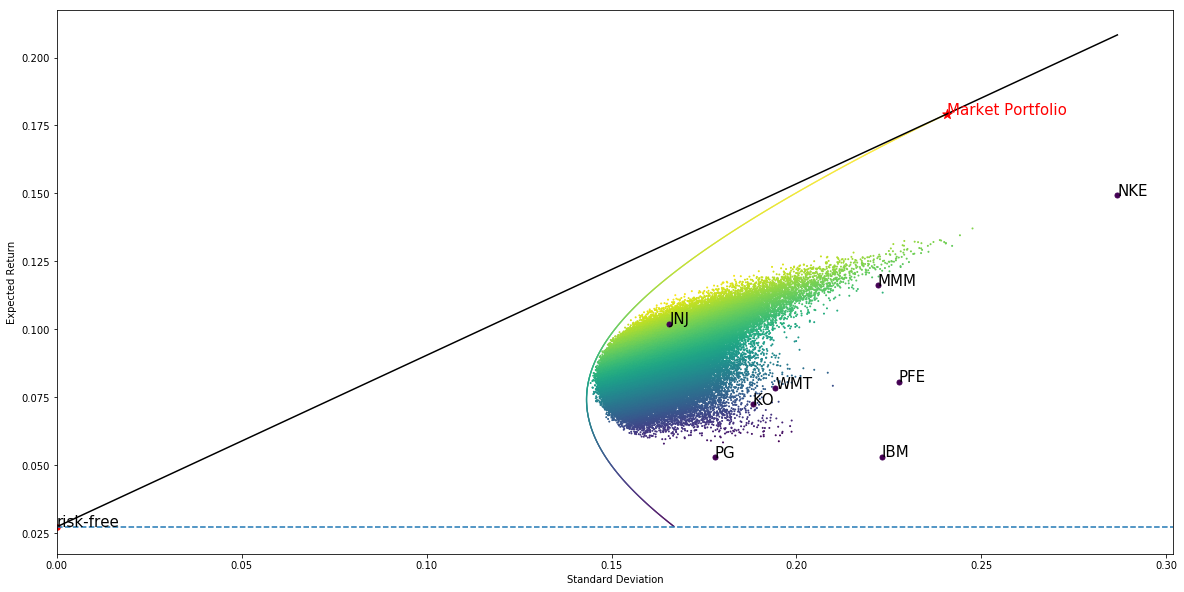

In [225]:
plt.figure(figsize = (20,10))
plt.scatter(simu_var,simu_rate,s=0.1,c = (pd.Series(simu_rate)-rf)/pd.Series(simu_var))
plt.scatter(simu_df.x,simu_df.y,s = 1,c =simu_df.sharpe)
plt.scatter(0,rf,color = 'r',s = 30)
plt.scatter(opt['std'],opt.rate,color = 'red',s = 100,marker = '*')
plt.annotate('risk-free',(0,rf),size = 15)
plt.annotate('Market Portfolio',(opt['std'],opt['rate']),size = 15,color = 'red')
for i in stocks:
    plt.scatter(df.ix[i.ticker][1],df.ix[i.ticker][0],s = 25,c = (df.ix[i.ticker][0]-rf)/df.ix[i.ticker][1])
    plt.annotate(i.ticker,(df.ix[i.ticker][1],df.ix[i.ticker][0]), size = 15)
plt.plot([0,max(std_list)],[rf,max(std_list)*opt['sharpe']+rf],color = 'black')
plt.xlim(0)
plt.xlabel('Standard Deviation')
plt.ylabel('Expected Return')
plt.axhline(rf,ls = '--')
plt.show()

In [ ]:
###three stocks version

In [234]:
def efficient_frontier(tickers):
    stocks = []
    leng = len(tickers)
    for i in tickers:
        vars()[i] = stock(i)
        stocks.append(vars()[i])
    
    rf = quandl.get('USTREASURY/LONGTERMRATES')
    rf = (rf.ix[-1][0]/100)
    for i in stocks:
        table = quandl.get('WIKI/%s'%i.ticker)
        i.rate = np.log(table['Adj. Close']).diff()['2008':]
        i.mean = np.mean(i.rate)*252
        i.std = np.std(i.rate)*np.sqrt(252)
        
    stock_list = [x.ticker for x in stocks]
    rate_list = [x.rate for x in stocks]
    mean_list = [x.mean for x in stocks]
    std_list = [x.std for x in stocks]
    cov_matrix = np.cov(rate_list)
    df = pd.DataFrame({'mean':mean_list,'std':std_list},index = stock_list)
    print df
    
    def min_var_generator(rate):
        def target(x, sigma, mean,r):
            sr_inv = (np.sqrt(np.dot(np.dot(x.T,sigma),x))*np.sqrt(252))/(x.dot(mean_list)-r)
            return sr_inv

        x = np.ones(leng)/leng
        mean = mean_list
        sigma = cov_matrix
        r = rf
        c = ({'type':'eq','fun':lambda x: sum(x) - 1},
            {'type':'eq','fun': lambda x: np.dot(x.T,mean) - rate})
        bounds = [(-1,1) for i in range(leng)]
        res = minimize(target, x, args = (sigma,mean,r),method = 'SLSQP',constraints = c,bounds = bounds)
        return (res['x'],(np.sqrt(np.dot(np.dot(res['x'].T,sigma),res['x']))*np.sqrt(252)))
    
    simu_rate = [x for x in np.arange(rf,max(mean_list)*1.2,0.0001)]
    simu_var = []
    for i in simu_rate:
        try:
            res = min_var_generator(i)
            simu_var.append(res[1])
        except:
            print i
    
    port_df = pd.DataFrame({'rate':simu_rate,'std':simu_var})
    port_df.head()
    port_df['sharpe'] = (port_df['rate'] - rf)/port_df['std']
    opt = port_df.ix[port_df['sharpe'].idxmax()]
    return port_df

In [235]:
new = efficient_frontier(['PG','IBM','KO'])

         mean       std
PG   0.052920  0.177927
IBM  0.053190  0.222997
KO   0.072506  0.188207


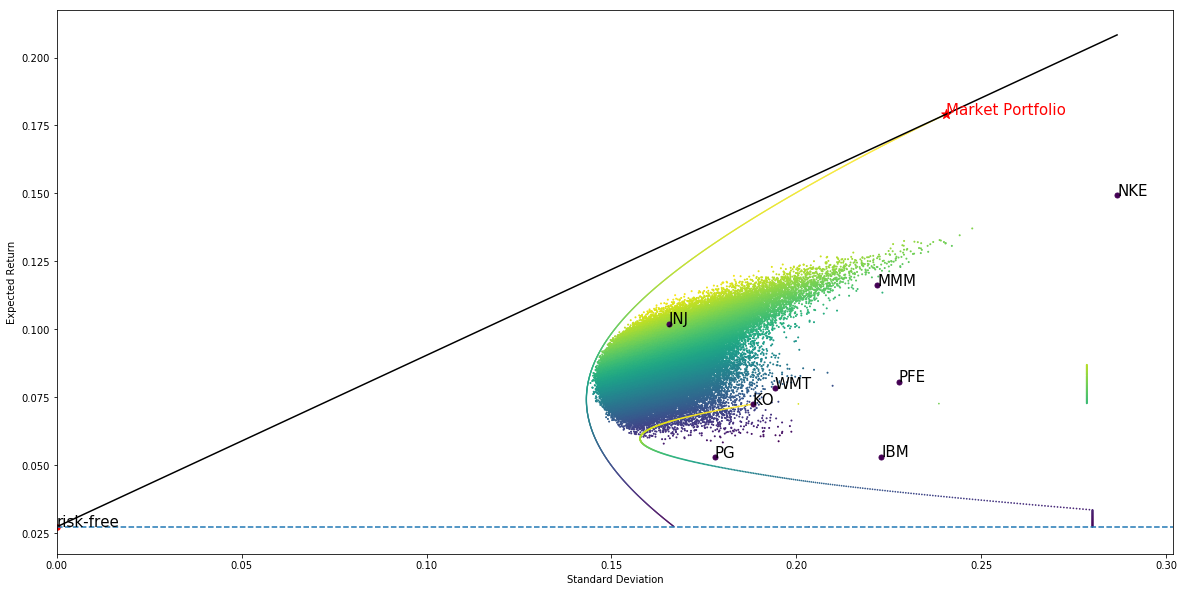

In [238]:
plt.figure(figsize = (20,10))
plt.scatter(simu_var,simu_rate,s=0.1,c = (pd.Series(simu_rate)-rf)/pd.Series(simu_var))
plt.scatter(simu_df.x,simu_df.y,s = 1,c =simu_df.sharpe)
plt.scatter(new['std'],new['rate'],c = new['sharpe'],s = 0.5)
plt.scatter(0,rf,color = 'r',s = 30)
plt.scatter(opt['std'],opt.rate,color = 'red',s = 100,marker = '*')
plt.annotate('risk-free',(0,rf),size = 15)
plt.annotate('Market Portfolio',(opt['std'],opt['rate']),size = 15,color = 'red')
for i in stocks:
    plt.scatter(df.ix[i.ticker][1],df.ix[i.ticker][0],s = 25,c = (df.ix[i.ticker][0]-rf)/df.ix[i.ticker][1])
    plt.annotate(i.ticker,(df.ix[i.ticker][1],df.ix[i.ticker][0]), size = 15)
plt.plot([0,max(std_list)],[rf,max(std_list)*opt['sharpe']+rf],color = 'black')
plt.xlim(0)
plt.xlabel('Standard Deviation')
plt.ylabel('Expected Return')
plt.axhline(rf,ls = '--')
plt.show()